In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
# importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt


In [7]:
model_path = '/kaggle/input/work/pytorch/work/1'

In [8]:
resnet9_path = '/kaggle/input/resnet9/pytorch/resnet9/1/resnet.pt'
resnet50_path = '/kaggle/input/resnet50/pytorch/resnet50/1/Resnet50.pt'

In [9]:
#Downloading Datasets


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)




100%|██████████| 9912422/9912422 [00:00<00:00, 105393978.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44065366.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29539059.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7105754.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
len(train_dataset)

60000

In [11]:
ls

data/


In [12]:
device

device(type='cuda')

In [14]:
# Adjust the latent dimension
latent_dim = 16

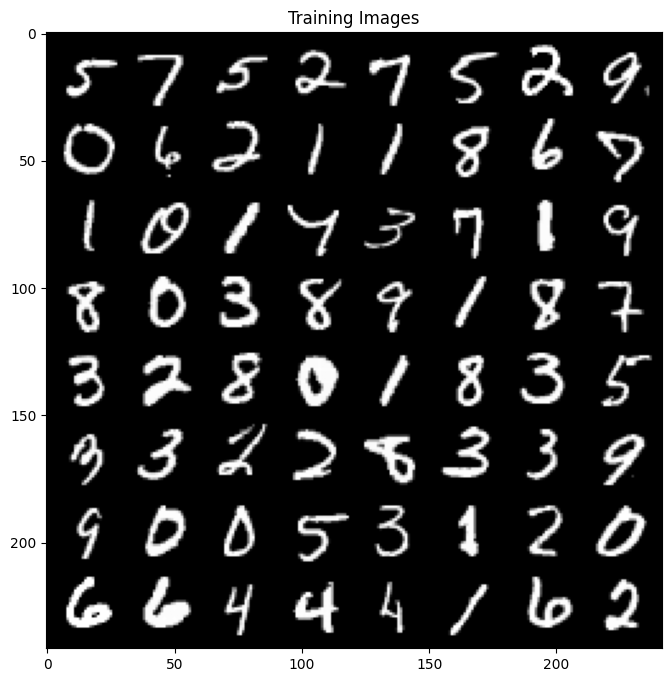

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [27]:
# autoencoder architecture

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = self.dropout1(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.dropout2(self.bn2(nn.functional.relu(self.conv2(x))))
        x = self.dropout3(self.bn3(nn.functional.relu(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Define the decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 128 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Adjusted stride, padding, and output padding
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)   # Adjusted stride, padding, and output padding
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)    # Adjusted padding

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = self.dropout1(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.dropout2(self.bn2(nn.functional.relu(self.conv2(x))))
        x = torch.sigmoid(self.conv3(x))
        return x




In [29]:
# working discriminator model
IMAGE_CHANNEL = 1

D_HIDDEN = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input size: (1 x 28 x 28)
            nn.Conv2d(1, D_HIDDEN, 4, 2, 1, bias=False),  # Output size: (D_HIDDEN x 14 x 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),  # Output size: (D_HIDDEN*2 x 7 x 7)
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 3, 1, 0, bias=False),  # Output size: (D_HIDDEN*4 x 5 x 5)
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 4, 1, 3, 1, 0, bias=False),  # Output size: (1 x 3 x 3)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [38]:
# creating an adversarial Autoencoder

# Define the adversarial autoencoder
class AAE(nn.Module):
    def __init__(self, latent_dim):
        super(AAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.discriminator = Discriminator()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [40]:
# Initialize AAE model
aae_model = AAE(latent_dim).to(device)

In [31]:
def train_aae(model, train_loader, criterion_recon, criterion_adv, optimizer_encoder, optimizer_decoder, optimizer_discriminator, epochs, adv_parameter):
    model.train()
    for epoch in range(epochs):
        total_loss_recon = 0.0
        total_loss_adv = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            optimizer_discriminator.zero_grad()

            # Real images from class 2 (label 2) for discriminator
            real_data = data[target == 2]

            # Forward pass through the AAE
            recon_data, encoded = model(data)

            # Reconstruction loss
            loss_recon = criterion_recon(recon_data, data)
            total_loss_recon += loss_recon.item()

            # Adversarial loss
            fake_output = model.discriminator(recon_data)
            real_output = model.discriminator(real_data)
            target_fake = torch.zeros_like(fake_output)
            target_real = torch.ones_like(real_output)
            loss_adv_fake = criterion_adv(fake_output, target_fake)
            loss_adv_real = criterion_adv(real_output, target_real)
            loss_adv = (loss_adv_fake + loss_adv_real) / 2
            total_loss_adv += loss_adv.item()
            # Total loss for decoder

            loss_decoder = loss_recon + adv_parameter * loss_adv

            # Backpropagation and optimization
            loss_decoder.backward(retain_graph=True)
            optimizer_decoder.step()

            # Train discriminator
            fake_output = model.discriminator(recon_data.detach())
            real_output = model.discriminator(real_data)
            loss_adv_fake = criterion_adv(fake_output, target_fake)
            loss_adv_real = criterion_adv(real_output, target_real)
            loss_adv = (loss_adv_fake + loss_adv_real) / 2
            loss_adv.backward()
            optimizer_discriminator.step()

            optimizer_encoder.step()

        print(f"Epoch {epoch+1}, Recon Loss: {total_loss_recon / len(train_loader)}, Adv Loss: {total_loss_adv / len(train_loader)}")
        # Store the trained model and its losses in the dictionary
        trained_models[adv_parameter] = {'model': aae_model, 'recon_loss': {total_loss_recon / len(train_loader)}, 'adv_loss': {total_loss_adv / len(train_loader)}}







In [32]:
# creating a dictionary

# Define a range of adv_parameter values
adv_parameters = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 20, 50, 100 ]

# Create a dictionary to store models and their losses
trained_models = {}


In [16]:

# Iterate over adv_parameter values
for adv_parameter in adv_parameters:
    # Create a new instance of the AAE model with the current adv_parameter
    aae_model = AAE(latent_dim).to(device)
    criterion_recon = nn.MSELoss()
    criterion_adv = nn.BCELoss()

    # Define optimizers for this model
    optimizer_encoder = optim.Adam(aae_model.encoder.parameters(), lr=0.001)
    optimizer_decoder = optim.Adam(aae_model.decoder.parameters(), lr=0.001)
    optimizer_discriminator = optim.Adam(aae_model.discriminator.parameters(), lr=0.001)

    # Train the model with the current adv_parameter
    train_aae(aae_model, train_loader, criterion_recon, criterion_adv, optimizer_encoder, optimizer_decoder, optimizer_discriminator, epochs=20, adv_parameter=adv_parameter)
    print("model training complete for", {adv_parameter})


Epoch 1, Recon Loss: 0.940358927890436, Adv Loss: 0.0030885608693134157
Epoch 2, Recon Loss: 0.8636196114615337, Adv Loss: 1.6379534853317316e-05
Epoch 3, Recon Loss: 0.8585645253978559, Adv Loss: 6.353631377192105e-06
Epoch 4, Recon Loss: 0.8564224107179053, Adv Loss: 3.4790072774656726e-06
Epoch 5, Recon Loss: 0.8545035538134544, Adv Loss: 2.152592850873575e-06
Epoch 6, Recon Loss: 0.8533696069646237, Adv Loss: 1.3969598856357852e-06
Epoch 7, Recon Loss: 0.8523371140839957, Adv Loss: 9.927828529225638e-07
Epoch 8, Recon Loss: 0.8509174426481414, Adv Loss: 7.136974563027039e-07
Epoch 9, Recon Loss: 0.8502710507368483, Adv Loss: 5.260732811610318e-07
Epoch 10, Recon Loss: 0.8497580541476512, Adv Loss: 3.856077959097147e-07
Epoch 11, Recon Loss: 0.8492916995274232, Adv Loss: 2.925917626658132e-07
Epoch 12, Recon Loss: 0.8487266252544134, Adv Loss: 2.2181688455321356e-07
Epoch 13, Recon Loss: 0.8484281715807884, Adv Loss: 1.687664179910114e-07
Epoch 14, Recon Loss: 0.8483137203686273, Ad

In [20]:
# saving the model

# Save trained models
for adv_parameter, model_info in trained_models.items():
    model = model_info['model']
    save_path = f"model_{adv_parameter}.pt"  # Choose a save path for each model
    torch.save(model.state_dict(), save_path)
    print(f"Model with adv_parameter={adv_parameter} saved at {save_path}")

Model with adv_parameter=0.001 saved at model_0.001.pt
Model with adv_parameter=0.01 saved at model_0.01.pt
Model with adv_parameter=0.05 saved at model_0.05.pt
Model with adv_parameter=0.1 saved at model_0.1.pt
Model with adv_parameter=0.5 saved at model_0.5.pt
Model with adv_parameter=1.0 saved at model_1.0.pt
Model with adv_parameter=5.0 saved at model_5.0.pt
Model with adv_parameter=10 saved at model_10.pt
Model with adv_parameter=20 saved at model_20.pt
Model with adv_parameter=50 saved at model_50.pt
Model with adv_parameter=100 saved at model_100.pt


In [22]:
ls /kaggle/input/

resnet50/


In [37]:
ls /kaggle/input/work/pytorch/work/1/model_0.001.pt

/kaggle/input/work/pytorch/work/1/model_0.001.pt


/kaggle/input/work/pytorch/work/1/model_0.001.pt

In [34]:
for adv_parameter in adv_parameters:
    
    print(save_path)

/kaggle/input/work/pytorch/work/1/model_0.001.pt
/kaggle/input/work/pytorch/work/1/model_0.01.pt
/kaggle/input/work/pytorch/work/1/model_0.05.pt
/kaggle/input/work/pytorch/work/1/model_0.1.pt
/kaggle/input/work/pytorch/work/1/model_0.5.pt
/kaggle/input/work/pytorch/work/1/model_1.0.pt
/kaggle/input/work/pytorch/work/1/model_5.0.pt
/kaggle/input/work/pytorch/work/1/model_10.pt
/kaggle/input/work/pytorch/work/1/model_20.pt
/kaggle/input/work/pytorch/work/1/model_50.pt
/kaggle/input/work/pytorch/work/1/model_100.pt


In [42]:
# Load saved models
adv = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 20, 100 ]
loaded_models = {}
for adv_parameter in adv:
    save_path = model_path + '/' f"model_{adv_parameter}.pt"  # Choose the same save path as used during saving
    loaded_model = AAE(latent_dim).to(device)
    loaded_model.load_state_dict(torch.load(save_path))
    loaded_models[adv_parameter] = loaded_model
    print(f"Model with adv_parameter={adv_parameter} loaded from {save_path}")

Model with adv_parameter=0.001 loaded from /kaggle/input/work/pytorch/work/1/model_0.001.pt
Model with adv_parameter=0.01 loaded from /kaggle/input/work/pytorch/work/1/model_0.01.pt
Model with adv_parameter=0.05 loaded from /kaggle/input/work/pytorch/work/1/model_0.05.pt
Model with adv_parameter=0.1 loaded from /kaggle/input/work/pytorch/work/1/model_0.1.pt
Model with adv_parameter=0.5 loaded from /kaggle/input/work/pytorch/work/1/model_0.5.pt
Model with adv_parameter=1.0 loaded from /kaggle/input/work/pytorch/work/1/model_1.0.pt
Model with adv_parameter=5.0 loaded from /kaggle/input/work/pytorch/work/1/model_5.0.pt
Model with adv_parameter=10 loaded from /kaggle/input/work/pytorch/work/1/model_10.pt
Model with adv_parameter=20 loaded from /kaggle/input/work/pytorch/work/1/model_20.pt
Model with adv_parameter=100 loaded from /kaggle/input/work/pytorch/work/1/model_100.pt


# creating and loading the resnet 50 architecture 


In [86]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

In [92]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [96]:
resnet50 = resnet34(NUM_CLASSES)

In [130]:
import torch.nn.functional as F



In [107]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

In [166]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_lo = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_lo = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)


In [122]:
len(test_loader)

313

In [123]:
len(test_lo)

79

**Creating test images with different epsilon Values**

In [51]:
####### test data ##############

import torch
from torchvision import datasets, transforms

# Define data transformation for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [67]:
len(test_loader)

313

In [60]:
for adv_param,model in loaded_models.items():
    print(loaded_models[adv_param].to(device))
    break
    
    
    

AAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.25, inplace=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout2d(p=0.25, inplace=False)
    (fc1): Linear(in_features=2048, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=16, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=6272, bias=True)
    (conv1): ConvTranspose2d(128,

In [127]:
def evaluate_loaded_models(loaded_models, test_loader, device, reconstructed_images):
    for adv_parameter, model in loaded_models.items():
        model = model.to(device)  # Move model to CUDA device
        model.eval()
        reconstructed_images[adv_parameter] = {'images': [], 'labels': []}

        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                recon_data, _ = model(data)
                reconstructed_images[adv_parameter]['images'].append(recon_data.cpu().numpy())
                reconstructed_images[adv_parameter]['labels'].append(target.numpy())

    return reconstructed_images

# Example usage
reconstructed_images_loaded = {}
reconstructed_images_loaded = evaluate_loaded_models(loaded_models, test_lo, device, reconstructed_images_loaded)


In [128]:
reconstructed_images_loaded.keys()

dict_keys([0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 20, 100])

Adv Parameter: 0.001


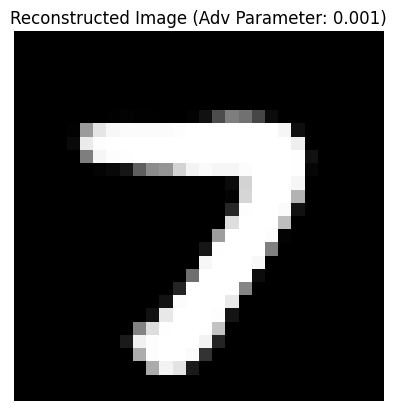

Adv Parameter: 0.01


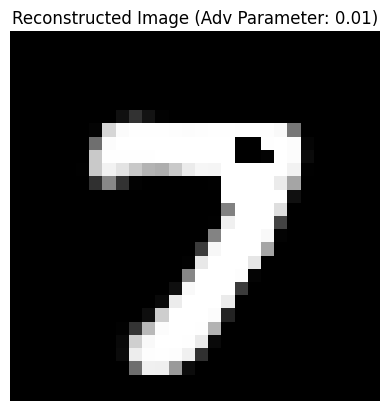

Adv Parameter: 0.05


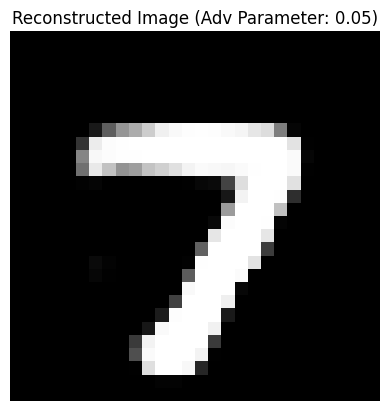

Adv Parameter: 0.1


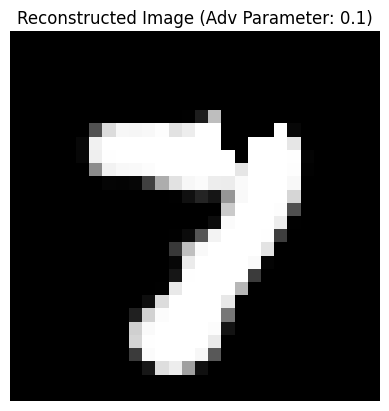

Adv Parameter: 0.5


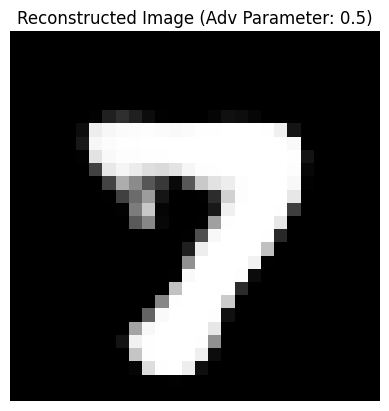

Adv Parameter: 1.0


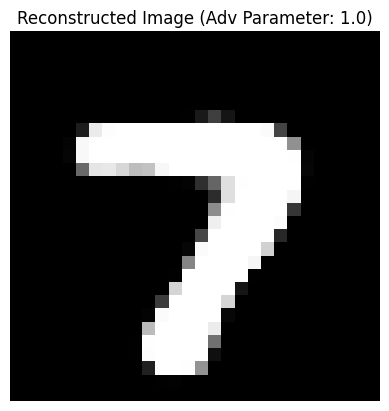

Adv Parameter: 5.0


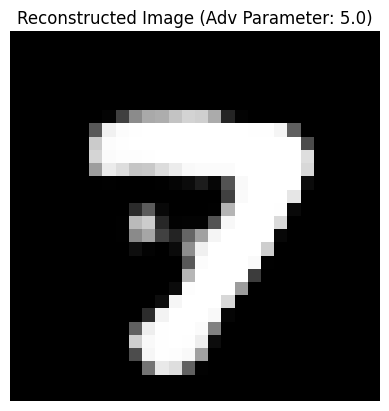

Adv Parameter: 10


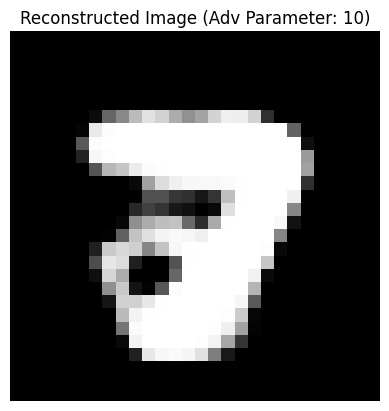

Adv Parameter: 20


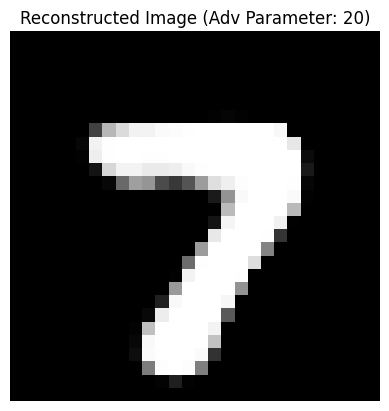

Adv Parameter: 100


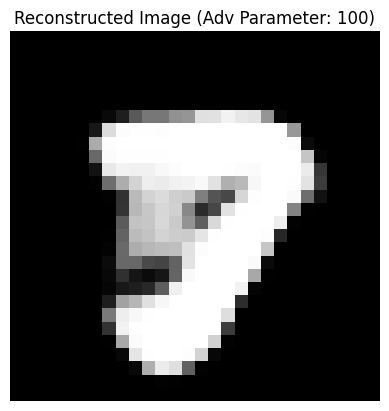

In [129]:
def print_one_image_per_adv_parameter(reconstructed_images):
    for adv_parameter, images_info in reconstructed_images.items():
        print(f"Adv Parameter: {adv_parameter}")
        reconstructed_image = images_info['images'][0]  # Select the first reconstructed image
        plt.imshow(np.squeeze(reconstructed_image[0]), cmap='gray')  # Plot the first image from the batch
        plt.axis('off')
        plt.title(f"Reconstructed Image (Adv Parameter: {adv_parameter})")
        plt.show()

# Example usage
print_one_image_per_adv_parameter(reconstructed_images_loaded)


In [ ]:
** ADVERSARIAL ATTACK ON RESNET 50 **


In [158]:
def compute_accuracy_on_reconstructed_images(model, reconstructed_images, device):
    for adv_parameter, data in reconstructed_images.items():
        try:
            images = data['images'][1]  # Retrieve the images for the first adv_parameter
            labels = data['labels'][1]

            images_tensor = torch.tensor(images).to(device)
            labels_tensor = torch.tensor(labels).to(device)

            logits, probas = model(images_tensor)
            _, predicted_labels = torch.max(probas, 1)
            num_examples = labels_tensor.size(0)
            correct_pred = (predicted_labels == labels_tensor).sum().item()
            accuracy = correct_pred / num_examples * 100
            print(f"Accuracy for adv_parameter {adv_parameter}: {accuracy:.2f}%")
        except Exception as e:
            continue

device = torch.device(DEVICE)
torch.manual_seed(0)
with torch.set_grad_enabled(False): # save memory during inference
    compute_accuracy_on_reconstructed_images(resnet50, reconstructed_images_loaded, device=DEVICE)


In [173]:
import numpy as np
import pandas as pd
#/kaggle/input/resnet50/pytorch/resnet50/1
def save_images_to_csv(reconstructed_images, output_dir):
    for adv_parameter, data in reconstructed_images.items():
        images_list = data['images'][0]  # Retrieve the images for the first adv_parameter
        labels_list = data['labels'][0]  # Retrieve the corresponding labels

        # Flatten or reshape the images
        flattened_images = [image.flatten() for image in images_list]
        # OR
        # reshaped_images = [image.reshape(-1) for image in images_list]

        # Convert the flattened or reshaped images and labels to DataFrames
        images_df = pd.DataFrame(flattened_images)
        labels_df = pd.DataFrame(labels_list, columns=['Label'])

        # Concatenate the images and labels along the columns
        df = pd.concat([labels_df, images_df], axis=1)

        # Save the DataFrame to a CSV file
        file_name = f"reconstructed_images_adv_{adv_parameter}.csv"
        file_path = os.path.join(output_dir, file_name)
        df.to_csv(file_path, index=False)
        print(f"CSV file saved: {file_path}")

# Example usage
output_dir = "/kaggle/working/"
save_images_to_csv(reconstructed_images_loaded, output_dir)


CSV file saved: /kaggle/working/reconstructed_images_adv_0.001.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_0.01.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_0.05.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_0.1.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_0.5.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_1.0.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_5.0.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_10.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_20.csv
CSV file saved: /kaggle/working/reconstructed_images_adv_100.csv


In [72]:
# Initialize AAE model
aae_model = AAE(latent_dim).to(device)
criterion_recon = nn.MSELoss()
criterion_adv = nn.BCELoss()

    # Define optimizers for this model
optimizer_encoder = optim.Adam(aae_model.encoder.parameters(), lr=0.001)
optimizer_decoder = optim.Adam(aae_model.decoder.parameters(), lr=0.001)
optimizer_discriminator = optim.Adam(aae_model.discriminator.parameters(), lr=0.001)

In [55]:
def train_aae1(model, train_loader, criterion_recon, criterion_adv, optimizer_encoder, optimizer_decoder, optimizer_discriminator, epochs, adv_parameter):
    model.train()
    for epoch in range(epochs):
        total_loss_recon = 0.0
        total_loss_adv = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            optimizer_discriminator.zero_grad()

            # Real images from class 2 (label 2) for discriminator
            real_data = data[target == 2]

            # Forward pass through the AAE
            recon_data, encoded = model(data)

            # Reconstruction loss
            loss_recon = criterion_recon(recon_data, data)
            total_loss_recon += loss_recon.item()

            # Adversarial loss
            fake_output = model.discriminator(recon_data)
            real_output = model.discriminator(real_data)
            target_fake = torch.zeros_like(fake_output)
            target_real = torch.ones_like(real_output)
            loss_adv_fake = criterion_adv(fake_output, target_fake)
            loss_adv_real = criterion_adv(real_output, target_real)
            loss_adv = (loss_adv_fake + loss_adv_real) / 2
            total_loss_adv += loss_adv.item()
            # Total loss for decoder

            loss_decoder = loss_recon + adv_parameter * loss_adv

            # Backpropagation and optimization
            loss_decoder.backward(retain_graph=True)
            optimizer_decoder.step()

            # Train discriminator
            fake_output = model.discriminator(recon_data.detach())
            real_output = model.discriminator(real_data)
            loss_adv_fake = criterion_adv(fake_output, target_fake)
            loss_adv_real = criterion_adv(real_output, target_real)
            loss_adv = (loss_adv_fake + loss_adv_real) / 2
            loss_adv.backward()
            optimizer_discriminator.step()

            optimizer_encoder.step()

        print(f"Epoch {epoch+1}, Recon Loss: {total_loss_recon / len(train_loader)}, Adv Loss: {total_loss_adv / len(train_loader)}")
        # Store the trained model and its losses in the dictionary
        #trained_models[adv_parameter] = {'model': aae_model, 'recon_loss': {total_loss_recon / len(train_loader)}, 'adv_loss': {total_loss_adv / len(train_loader)}}







In [74]:
train_aae1(aae_model, train_loader, criterion_recon, criterion_adv, optimizer_encoder, optimizer_decoder, optimizer_discriminator, epochs=10, adv_parameter=10)
    

Epoch 1, Recon Loss: 1.054899540918468, Adv Loss: 0.002574248413842577
Epoch 2, Recon Loss: 0.8744334307814966, Adv Loss: 4.4499709340815085e-05
Epoch 3, Recon Loss: 0.8617070524423107, Adv Loss: 7.2444848268523875e-06
Epoch 4, Recon Loss: 0.8574262624864639, Adv Loss: 3.4181749074406963e-06
Epoch 5, Recon Loss: 0.8548113955363535, Adv Loss: 1.934216224021441e-06
Epoch 6, Recon Loss: 0.8534506689002519, Adv Loss: 1.245545988156951e-06
Epoch 7, Recon Loss: 0.8518877995293787, Adv Loss: 8.436499965774855e-07
Epoch 8, Recon Loss: 0.8510202159251231, Adv Loss: 6.02724886923038e-07
Epoch 9, Recon Loss: 0.8503932055633968, Adv Loss: 5.58082302762514e-07
Epoch 10, Recon Loss: 0.8498527985900196, Adv Loss: 3.3151051015707213e-07


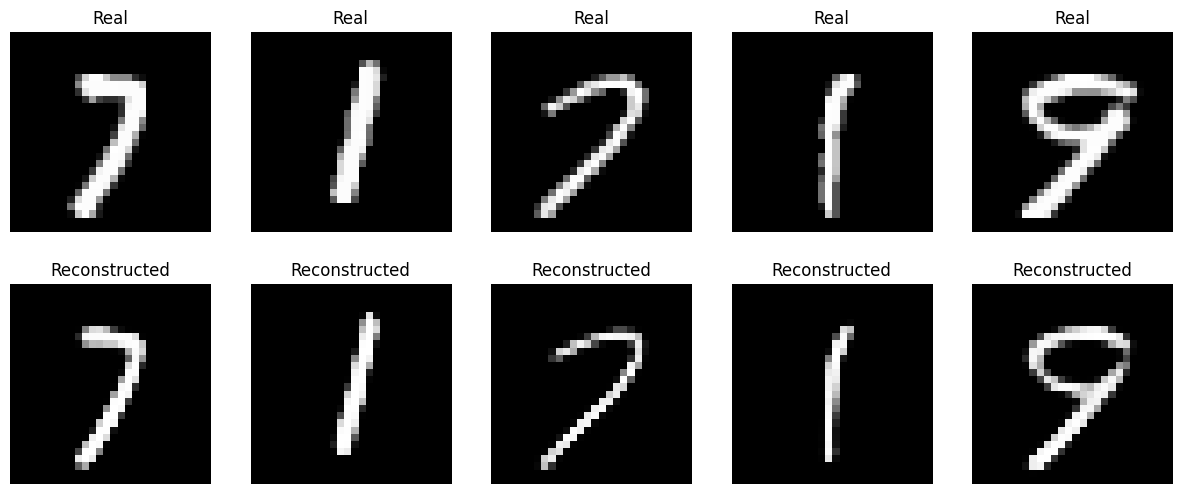

In [76]:
plot_real_vs_reconstructed(aae_model, train_loader, device)

In [80]:
import torch
from torchvision import datasets, transforms

# Define data transformation for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [95]:
reconstructed_images = {}
def evaluate_aae_models(trained_models, test_loader, device):
    for adv_parameter, model_info in trained_models.items():
        model = model_info['model'].to(device)  # Move model to CUDA device
        model.eval()
        reconstructed_images[adv_parameter] = {'images': [], 'labels': []}

        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                recon_data, _ = model(data)
                reconstructed_images[adv_parameter]['images'].append(recon_data.cpu().numpy())
                reconstructed_images[adv_parameter]['labels'].append(target.numpy())

    






In [96]:
# Example usage
evaluate_aae_models(trained_models, test_loader, device)

0.001
0.01
0.05
0.1
0.5
1.0
5.0
10
20
50
100


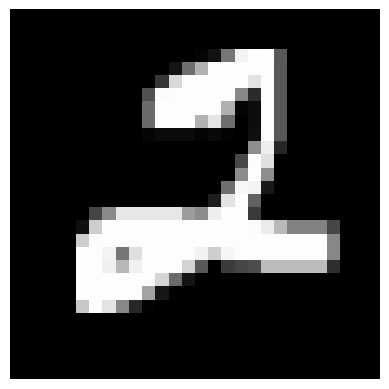

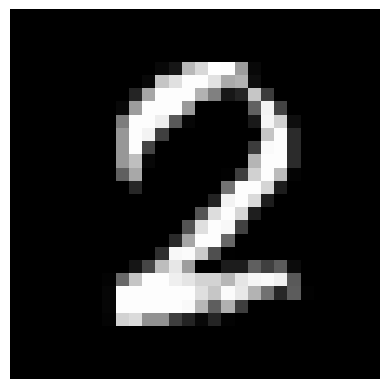

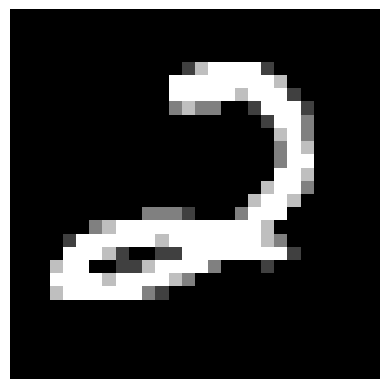

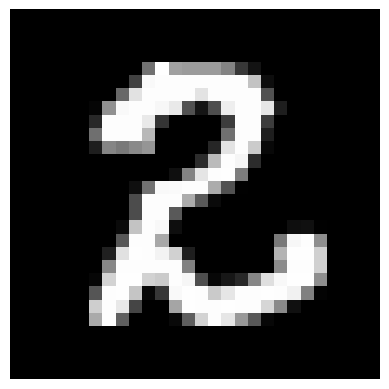

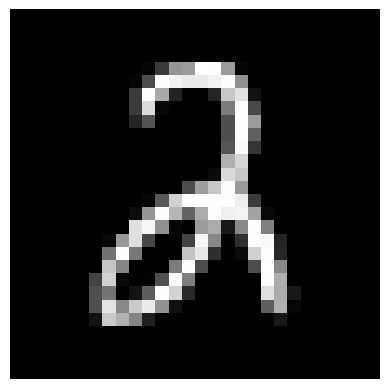

In [45]:
import matplotlib.pyplot as plt

# Loop over the data loader to find 5 samples with label 2
count = 0
for data, target in train_loader:
    real_data = data[target == 2]
    if len(real_data) > 0:
        for img in real_data:
            # Plot the image
            plt.imshow(img.squeeze(), cmap='gray')
            plt.axis('off')
            plt.show()
            count += 1
            if count >= 5:
                break
    if count >= 5:
        break
